# King County, Washington State, USA - Housing Prices

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy import optimize
import numpy as np
from sklearn.model_selection import train_test_split
from scipy import optimize
from matplotlib import pyplot
import sys
from tqdm import tqdm as tqdm
from matplotlib.pyplot import figure
%matplotlib inline

<Figure size 432x288 with 0 Axes>

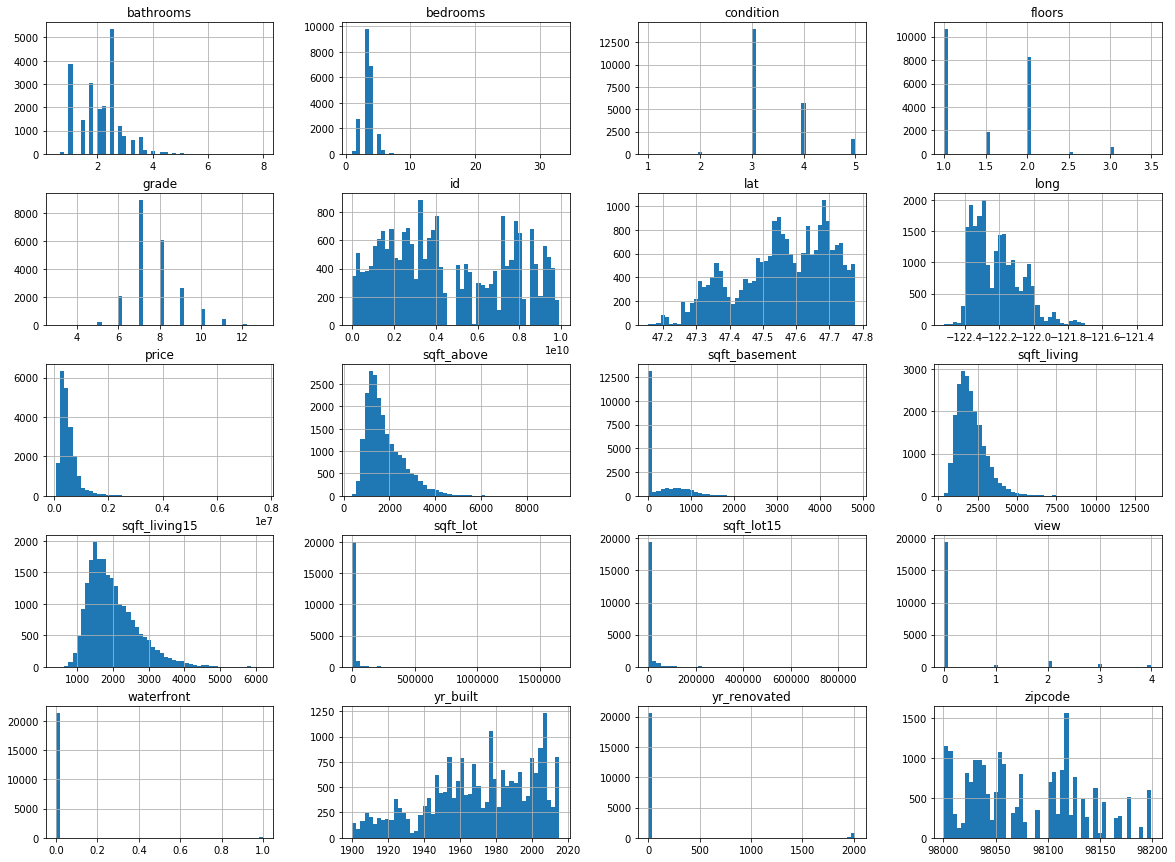

In [79]:
data = pd.read_csv("Data/kc_house_data.csv")
plt.figure()
data.hist(figsize=(20, 15), bins=50)
#scatter_matrix(data)
plt.show()

# Data Preparation

In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null int64
view             21597 non-null int64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null int64
yr_built         21597 non-null int64
yr_renovated     21597 non-null int64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(5), int64(15), object(1)
memory usage: 3.5+ MB


In [81]:
def data_preprocessing(data):
    #Returns processed data in numpy matrix
    #Drops ID field and converts date to year only
    data_w = data
    data_w = data.drop(columns=['id'])
    data_w["date"] = pd.to_datetime(data_w["date"]).dt.year
    
    #move price to the end of df
    price = data_w.pop('price')
    data_w['price']=price
    return data_w.values


In [82]:
#Split data into train and test set
data_X = data_preprocessing(data)
X, X_test, y, y_test = train_test_split(data_X[:, :18], data_X[:, 19], test_size=0.20, random_state=23)

#Set aside test set
test_set = np.concatenate([X_test, y_test[:, None]], axis=1)
np.savetxt("Data/test_data.txt", test_set, fmt='%s')

#Split data into train and cross validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=23)


# Linear Regression Model

In [83]:
# Cost Function
def linearRegCostFunction(X, y, theta, lambda_):
    
    # Initialize some useful values
    m, n = X.shape # X matrix shape
    
    
    #Add intercept
    #print(np.ones(m).reshape(m,1).shape, X)
    X = np.concatenate([np.ones(m).reshape(m,1), X], axis=1)
    
    #Compute h
    h = X @ theta
    
    #Regularized Cost Function
    J = np.sum((h - y)**2)/(2*m)
    reg_term = (lambda_/(2*m)) * np.sum(theta[1:]**2)
    J = J + reg_term
    
    #Gradient Computation
    #Simple Gradient without reg for bias
    grad = (1/m) * ((h - y) @ X)
    
    # Compute gradient with reg for non-bias
    grad[1:] = grad[1:] + (lambda_/m)*theta[1:]

    return J, grad

def trainLinearReg(linearRegCostFunction, X, y, lambda_=0.0, maxiter=200):

    # Initialize Theta
    initial_theta = np.zeros(18+1)

    # Create "short hand" for the cost function to be minimized
    costFunction = lambda t: linearRegCostFunction(X, y, t, lambda_)

    # Now, costFunction is a function that takes in only one argument
    options = {'maxiter': maxiter}

    # Minimize using scipy
    res = optimize.minimize(costFunction, initial_theta, jac=True, method='TNC', options=options)
    
    return res.x

def learningCurve(X_train, y_train, X_val, y_val, lambda_=0):
    # Number of training examples
    m = y_train.size

    # You need to return these values correctly
    error_train = np.zeros(m)
    error_val   = np.zeros(m)

    #Compute error_train
    for i in tqdm(range(1, m+1)):
        theta_train = trainLinearReg(linearRegCostFunction, X_train[:i,:], y_train[:i], lambda_)
        
        error_train[i-1], _ = linearRegCostFunction(X_train[:i, :], y_train[:i], theta_train, 0)
        error_val[i-1], _ = linearRegCostFunction(X_val, y_val, theta_train, 0)
        
    return error_train, error_val

In [84]:
## testing cost function
#test theta with ones
theta_test = np.ones(18+1)
lambda_ = 0
# Compute cost with test theta
J, grad = linearRegCostFunction(X_train, y_train, theta_test, lambda_)
J, grad

(155997289530.55603,
 array([ -4.20703778e+05,  -8.47432310e+08,  -1.52396788e+06,
         -1.03822996e+06,  -1.10827651e+09,  -6.17402134e+09,
         -6.79801744e+05,  -1.26168424e+04,  -2.14740669e+05,
         -1.44249125e+06,  -3.50842715e+06,  -9.31911706e+08,
         -1.76364799e+08,  -8.29669771e+08,  -5.60134285e+07,
         -4.12611268e+10,  -2.00250050e+07,   5.14164449e+07,
         -9.82266274e+08]))

In [85]:
#Train Model
res = trainLinearReg(linearRegCostFunction, X_train, y_train, lambda_=0.0, maxiter=200)
trained_theta = res

#Test model on cross validation set
results = predict(X_val, trained_theta)

results

array([ 659576.1100922 ,  209262.92481481,  358537.11954322, ...,
        756686.8650065 ,  597383.19170907,  330664.68151083])

In [ ]:
#Compute Training and Validation error for increasing number of training data used
error_train, error_val = learningCurve(X_train, y_train, X_val, y_val, lambda_=0)


# ML Diagnostics
## Learning Curve

# Training Examples	Train Error	Cross Validation Error
  	1		0.000000	102374657935.698959
  	2		0.000000	6502539544331.119141
  	3		0.000000	138983589253528.640625
  	4		0.000000	210865818554.733582
  	5		0.000000	107406791787.992386
  	6		0.000024	467763712092.462036
  	7		0.000079	104776544203.061264
  	8		0.209028	66306807843.456093
  	9		1158606.936010	161361944543.586731
  	10		125003212.457457	94274903558.911789


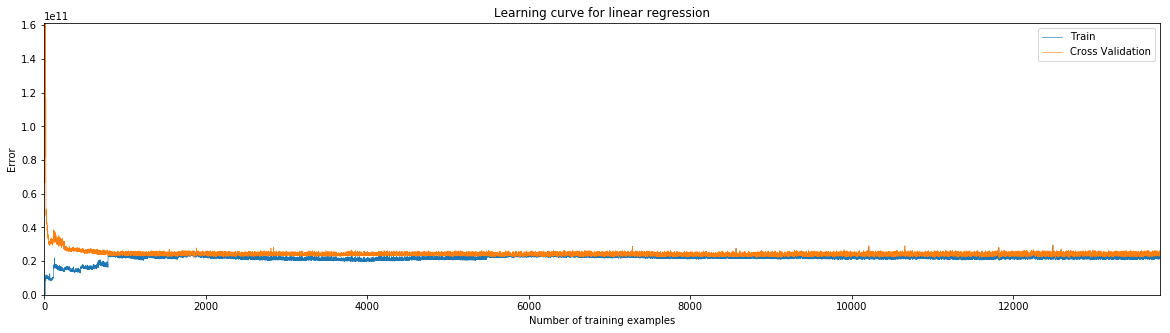

In [86]:
#Plot Learning Curves
m = y_train.size

print('# Training Examples\tTrain Error\tCross Validation Error')
for i in range(10):
    print('  \t%d\t\t%f\t%f' % (i+1, error_train[i], error_val[i]))


figure(num=1, figsize=(20, 5))
pyplot.plot(np.arange(1, m+1), error_train, np.arange(1, m+1), error_val, lw=0.6)
pyplot.title('Learning curve for linear regression')
pyplot.legend(['Train', 'Cross Validation'])
pyplot.xlabel('Number of training examples')
pyplot.ylabel('Error')
pyplot.axis([0, m, 0, 161361944543])

pyplot.show()

    

## Learning Curve - Interpretation

- Graph Properties
    - Low training set size: J_CV is high & J_train is low
    - Large training set size: J_CV ≃ J_train
    
-> Model does not seem to suffer from high variance but from high bias

Steps to address high bias situation:
- Adding features: <span style="color:orange">Not possible, look into feauture engineering</span> 
- Adding polynomial features: <span style="color:green">Next Step</span> 
- After polynomials: determine best lambda: <span style="color:green">Next Step</span> 

# Adding Polynomial Features